In [1]:
import os
# print(os.getcwd())

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action="ignore")

from scipy.stats import spearmanr
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import utils

# Config
sns.set_context('notebook', font_scale=1.3)

## Functions

In [2]:
def plot_user_trajectory_var4(
    data,
    pat_id,
    var,
    time_col="days_since_first_session",
    var_error=None,
    hue_query_fit=None,
    hue_names_fit=None,
    hue_query_plot=None,
    hue_names_plot=None,
    plot_all_efforts=False,
    ax=None,
    title=None,
    figsize=(5, 3),
    do_legend=False,
    legend_loc=(0.5, 0.5),
    fs=12,
    ylabel=None,
    xlabel=None,
    fill_between=True,
    plot_regression_line=True,
    extend_regression=False,
    alpha=[0.9, 0.9],  # [0.7, 0.85],
    marker=["o", "+"],
    size=[50, 140],
    color_1="blue",
    color_2="green",
    color_3="red",
    color_4="red",
    alpha_lr=1,
    **kwargs,
):
    """
    Plot user trajectory for a specific variable.

    Parameters:
    - data: DataFrame containing the data.
    - pat_id: Patient ID.
    - var: Variable to plot.
    - var_error: Error variable (optional).
    - hue_query: Query for hue levels (optional).
    - hue_names: Names for hue levels (optional).
    - plot_all_efforts: Whether to plot all efforts (optional).
    - time_col: time unit column to use (days, months, years).
    - ax: Axes object to plot on (optional).
    - title: Title of the plot (optional).
    - figsize: Figure size (optional).
    - do_legend: Whether to show the legend (optional).
    - fs: Font size (optional).
    - **kwargs: Additional keyword arguments for plotting.

    Returns:
    - DataFrame: DataFrame containing all efforts.
    """
    try:
        if var.startswith("fvc"):
            # esto para las distintas variantes de 'fvc' como percpred o 2019
            df1 = data.query('subject_order == @pat_id and pftType=="fvc"').copy()
        elif var.startswith("vc"):
            df1 = data.query('subject_order == @pat_id and pftType=="svc"').copy()
        else:
            df1 = data.query("subject_order == @pat_id").copy()

        assert time_col in df1.columns, f"ERROR: {time_col} column not found"

        if var == "svc":
            # SVC se llama en realidad vc en el dataframe pero el pftType es svc
            var = "vc"
        # Drop NaNs in the variable column and corresponding dates
        df1 = df1.dropna(subset=[var, time_col])
    except KeyError:
        print(f"Patient with no {var.upper()}")
        return

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)

    # Main curve
    if hue_query_plot is not None:
        q1_plot, q2_plot = hue_query_plot
        if q1_plot is None and q2_plot is not None:
            df_plot = df1.query(f"{q2_plot}")
        elif q1_plot is not None and q2_plot is None:
            df_plot = df1.query(f"{q1_plot}")
        else:
            df_plot = df1.copy()
    else:
        df_plot = df1.copy()

    if var_error is not None:
        ax.fill_between(
            df_plot[time_col].values,
            df_plot[var].values - df_plot[var_error].values,
            df_plot[var].values + df_plot[var_error].values,
            color="gray",
            alpha=0.2,
        )

    if not plot_all_efforts:

        if hue_query_fit is None:
            l1_fit = hue_names_fit
            x1_fit = df1[time_col].values
            y1_fit = df1[var].values
        else:
            q1_fit, _ = hue_query_fit
            x1_fit = df1.query(q1_fit)[time_col].values
            y1_fit = df1.query(q1_fit)[var].values

        if hue_query_plot is None:
            l1_plot = hue_names_plot
            x1_plot = df1[time_col].values
            y1_plot = df1[var].values
        else:
            q1_plot, q2_plot = hue_query_plot
            l1_plot, l2_plot = hue_names_plot
            x1_plot = df1.query(q1_plot)[time_col].values
            y1_plot = df1.query(q1_plot)[var].values
            if q2_plot is not None:
                x2_plot = df1.query(q2_plot)[time_col].values
                y2_plot = df1.query(q2_plot)[var].values

        # Plot good quality points
        ax.scatter(
            x1_plot,
            y1_plot,
            color=color_2,
            marker=marker[0],
            alpha=alpha[0],
            # facecolors="none",
            label=l1_plot,
            s=size[0],
        )

        # Regression Line
        if len(x1_fit) < 3 or len(y1_fit) < 3:
            p_value = np.nan
        else:
            (
                y_pred,
                lower_bound,
                upper_bound,
                p_value,
                slope,
                _,
                intercept,
                _,
            ) = utils.fit_regression(x1_fit, y1_fit, output_all=True)
            if extend_regression:
                # Extend backwards
                x1_fit = np.append(x1_fit, 0)
                y_pred = np.append(y_pred, intercept)

                # Extend forward
                x1_fit = np.append(x1_fit, 15)
                y_pred = np.append(y_pred, 15 * slope + intercept)

            if plot_regression_line:
                ax.plot(
                    x1_fit,
                    y_pred,
                    color=color_4,
                    alpha=alpha_lr,
                    linewidth=2,
                    label=None,
                )
                if fill_between:
                    ax.fill_between(
                        x1_fit, lower_bound, upper_bound, color="lightgrey", alpha=0.2
                    )

        # Plot bad quality points
        if hue_query_plot is not None:
            if q2_plot is not None:
                ax.scatter(
                    x2_plot,
                    y2_plot,
                    color=color_3,
                    marker=marker[-1],
                    alpha=alpha[-1],
                    # facecolors="none",
                    facecolors="white",
                    label=l2_plot,
                    s=size[-1],
                )

        if do_legend:
            ax.legend(loc=(legend_loc))

    # Add each effort
    if plot_all_efforts:
        all_eff = []
        for idx, row in df1.iterrows():
            date = row[time_col]
            efforts = row["efforts"]
            for i, effort in enumerate(efforts):
                if var in effort:
                    all_eff.append(
                        (date, row["session_id_hash"], i, effort[var], row["is_proctored"])
                    )
                    ax.scatter(
                        date,
                        effort[var],
                        color="blue" if row["is_proctored"] else "red",
                        marker="o" if row["is_proctored"] else "+",
                        alpha=0.5,
                        label="Efforts",
                        s=100,
                    )

    ax.set_xlabel(
        xlabel,
        fontdict={"fontsize": fs},
    )
    
    ax.set_yticks([0, 50, 100, 150])
    ax.set_yticklabels([0, 50, 100, 150])
    
    if ylabel is None:
        ylabel = var.upper()
    ax.set_ylabel(ylabel, fontdict={"fontsize": fs})
    if time_col == "date_only":
        ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="both", which="major", labelsize=fs)
    ax.tick_params(axis="both", which="minor", labelsize=fs)

    if title is not None:
        ax.set_title(title, fontdict={"fontsize": fs})
    else:
        ax.set_title(f"subject_order: {pat_id[:8]}", fontdict={"fontsize": fs})
    ax.grid(True)

    if ax is None:
        plt.show()
    if do_legend:
        ax.legend(loc=(legend_loc))

    if plot_all_efforts:
        return pd.DataFrame(
            all_eff, columns=["date", "session_id_hash", "id", var, "proctored"]
        )

def plot_trajectory_panels3(
    data: pd.DataFrame,
    pat_list: list,
    data_dict: list,
    time_col="days_since_first_session",
    limit=2,
    n_rows=4,
    n_cols=5,
    figsize=(35 * 0.5, 20 * 0.5),
    posicion_text_der = 1.19,
    plot_regression_line=True,
    fill_between=True,
    extend_regression=False,
    do_differt_color=[],
    ylim=None,
    xlim=None,
    mute_titles=True,
    mute_right_ticks=True,
    do_external_legend=False,
    mute_x_ticks=False,
    label_y={},
    xlabel=None,
    titles=None,
    **kwargs,
):
    """
    Plot trajectory panels for multiple patients.

    Args:
        data (pd.DataFrame): The data containing patient trajectories.
        pat_list (list): A list of patient IDs to plot.
        var (list): list of variables to plot.
        limit (float, optional): The number of standard deviations to plot as a threshold. Defaults to 2.
        n_rows (int, optional): The number of rows in the subplot grid. Defaults to 4.
        n_cols (int, optional): The number of columns in the subplot grid. Defaults to 5.
        figsize (tuple, optional): The figure size. Defaults to (35, 20).
        ylim (tuple, optional): The y-axis limits. Defaults to None.
        do_differt_color (list, optional): list of subjects to plot in a different color.
        **kwargs: Additional keyword arguments to pass to the `plot_user_trajectory_var` function.

    Returns:
        None
    """

    fig, axs = plt.subplots(
        n_rows,
        n_cols,
        figsize=figsize,
        sharex=False,
        sharey=True,
        constrained_layout=True,
    )
    axs = axs.flatten()
    less_pat = False
    if len(pat_list) < n_rows * n_cols: less_pat = True
    # print(len(pat_list))
    # print(less_pat)
    for i, pat in enumerate(pat_list):
        for i2, value in enumerate(data_dict):
            key = value["var_name"]
            list_of_kwargs = [
                "hue_query_fit",
                "hue_names_fit",
                "hue_query_plot",
                "hue_names_plot",
                "alpha",
                "marker",
                "size",
                "color_1",
                "color_2",
                "color_3",
                "color_4",
                "alpha_lr",
            ]
            for l in list_of_kwargs:
                if l in value.keys():
                    kwargs.update({l: value[l]})

            a = plot_user_trajectory_var4(
                data,
                pat,
                key,
                time_col=time_col,
                fill_between=fill_between,
                plot_regression_line=plot_regression_line,
                extend_regression=extend_regression,
                ax=axs[i],
                title=titles[i] if titles is not None else None,
                **kwargs,
            )

            if limit is not None:
                datpat = data.query("subject_order == @pat")
                m, s = datpat[key].mean(), datpat[key].std()
                axs[i].axhline(
                    limit * s + m, color="red", linestyle="dashdot", label=f"{limit} std"
                )
                axs[i].axhline(-1 * limit * s + m, color="red", linestyle="dashdot")
                handles, labels = axs[i].get_legend_handles_labels()
                axs[i].legend(handles, labels)

            # Clean X labels and ticks
            # if xlabel is not None:
            #     axs[i].set_xlabel(xlabel)
            if i >= (len(pat_list) - n_cols):  # Last row of used patient plots
                axs[i].set_xlabel(xlabel)
            if mute_x_ticks:
                if i < (n_rows - 1) * n_cols:
                    axs[i].set_xticklabels("")
                    # axs[i].set_xlabel("")

            # Clean Y labels and ticks
            if i2 > 0:
                # axs[i] = axs[i].twinx()
                if (i + 1) % n_cols != 0:
                    axs[i].set_ylabel("")
                # else:
                #     try:
                #         axs[i].set_ylabel(label_y[key], fontsize=15)
                #     except KeyError:
                #         axs[i].set_ylabel(key)
            else:
                if i % n_cols != 0:
                    axs[i].set_ylabel("")
                else:
                    try:
                        axs[i].set_ylabel(label_y[key], fontsize=15)
                    except KeyError:
                        axs[i].set_ylabel(key)

            if mute_titles:
                axs[i].set_title("")

            # set xlims y ylims
            if ylim is not None:
                if isinstance(ylim, list):
                    axs[i].set_ylim(ylim[i2])
                else:
                    axs[i].set_ylim(ylim)
            if xlim is not None:
                axs[i].set_xlim(xlim)
                
            if i2 > 0 and ((i % n_cols) == n_cols-1):
                axs[i].set_ylabel("")
                axs[i] = axs[i].twinx()
                axs[i].set_yticks([0,50,100,150])
                axs[i].set_ylabel("SVC % predicted", fontsize = 16)
                
        # Turn off unesed subplots
        for i3 in range(len(pat_list), n_rows * n_cols):
           axs[i3].axis("off")

        # Change color if for special subjects
        if pat in do_differt_color:
            axs[i].spines["top"].set_color("green")
            axs[i].spines["right"].set_color("green")
            axs[i].spines["bottom"].set_color("green")
            axs[i].spines["left"].set_color("green")
            print(f"{i}: {pat}")
        
    # Ajustes exteriores        
    axs[0].legend(loc="lower right")    
    for i in range(len(pat_list)):
        axs[i].set_xticks([0,4,8,12,16])
        if i % n_cols == 0:
            axs[i].set_ylabel("FVC % predicted", fontsize = 16)
        if i % n_cols == n_cols-1:
            axs[i].set_ylabel("")
            axs[i].text(posicion_text_der, 0.5, 'SVC % predicted', 
                        va='center',
                        ha='left',
                        rotation=270,#'vertical',
                        fontsize = 15,
                        transform=axs[i].transAxes)
        if less_pat:
            if i >= (len(pat_list) - n_cols):
                axs[i].set_xlabel(xlabel)
                xticks = axs[i].get_xticks()
                xticklabels = [f"{int(tick)}" for tick in xticks]
                axs[i].set_xticklabels(xticklabels)            
    

    # plt.tight_layout()
    # plt.show()
    return fig


## Data

In [3]:
PATH = 'data'
FILE = 'data_figsup1.csv'
df_data = pd.read_csv(os.path.join(PATH,FILE))

# # # Keep only those with at least one of each
# # subs = df_data.groupby('subject_order').apply(lambda s: s.is_proctored.nunique()==2)
# # subs = subs[subs].index
# # df_data = df_data.query('subject_order in @subs')

# print(f'N subjects: {df_data.subject_order.nunique()}')
# print(f"N proctored sessions: {df_data.query('is_proctored==True').session_id_hash.nunique()}")
# print(f"N non-proctored sessions: {df_data.query('is_proctored==False').session_id_hash.nunique()}")
# print(f"N sessions: {df_data.session_id_hash.nunique()}")
# df_data.head(3)

## Figure

In [4]:
colors = sns.color_palette("colorblind").as_hex()
# colors = ['#332288', '#117733', '#CC6677', '#882255']

data_dict_fvc_svc = [
    {'var_name': 'fvcPercPred_2019',
    'hue_query_fit': [
            'is_proctored', None
    ],
    'hue_names_fit':  [None, None],
    'hue_query_plot': [ 
        'is_proctored', 'not is_proctored'
    ],
    'hue_names_plot': ['FVC proc', 'FVC non-proc'],
    'alpha': [1, 1],
    'marker':['o'],
    'size':[50, 50],
    'alpha_lr': 1,
    'color_1': 'blue',
    'color_2': colors[0],#'#5d6e9e',
    'color_3': colors[0],#'#d1d0de', #light
    'color_4': 'blue',
    },
    
    {'var_name': 'vcPercPred',
    'hue_query_fit': [
            'is_proctored', None
    ],
    'hue_names_fit':  [None, None],
    'hue_query_plot': [ 
        'is_proctored', 'not is_proctored'
    ],
    'hue_names_plot': ['SVC proc', 'SVC non-proc'],
    'alpha': [1, 1],
    'marker':['o'],
    'size':[50, 50],
    'alpha_lr':1,
    'color_1': 'blue',
    'color_2': colors[3],#'#c59434',
    'color_3': colors[3],#'#f4d4d4', #light
    'color_4': 'blue'
    },
]

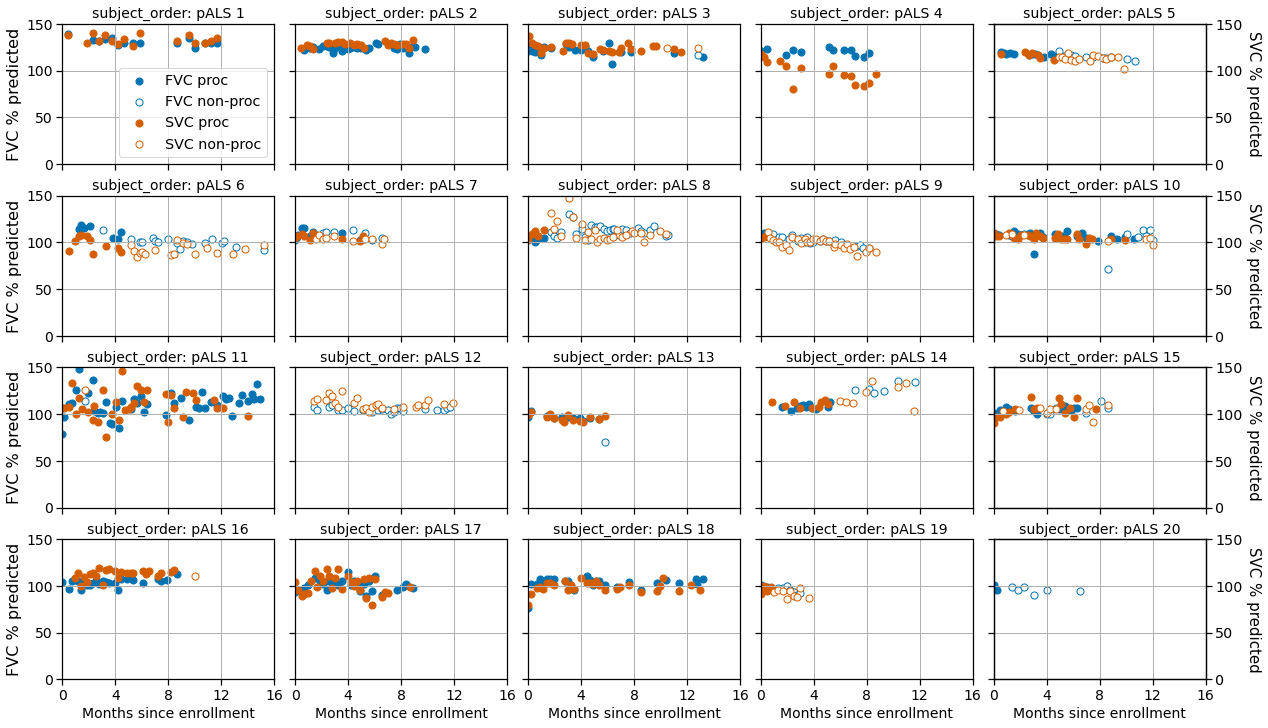

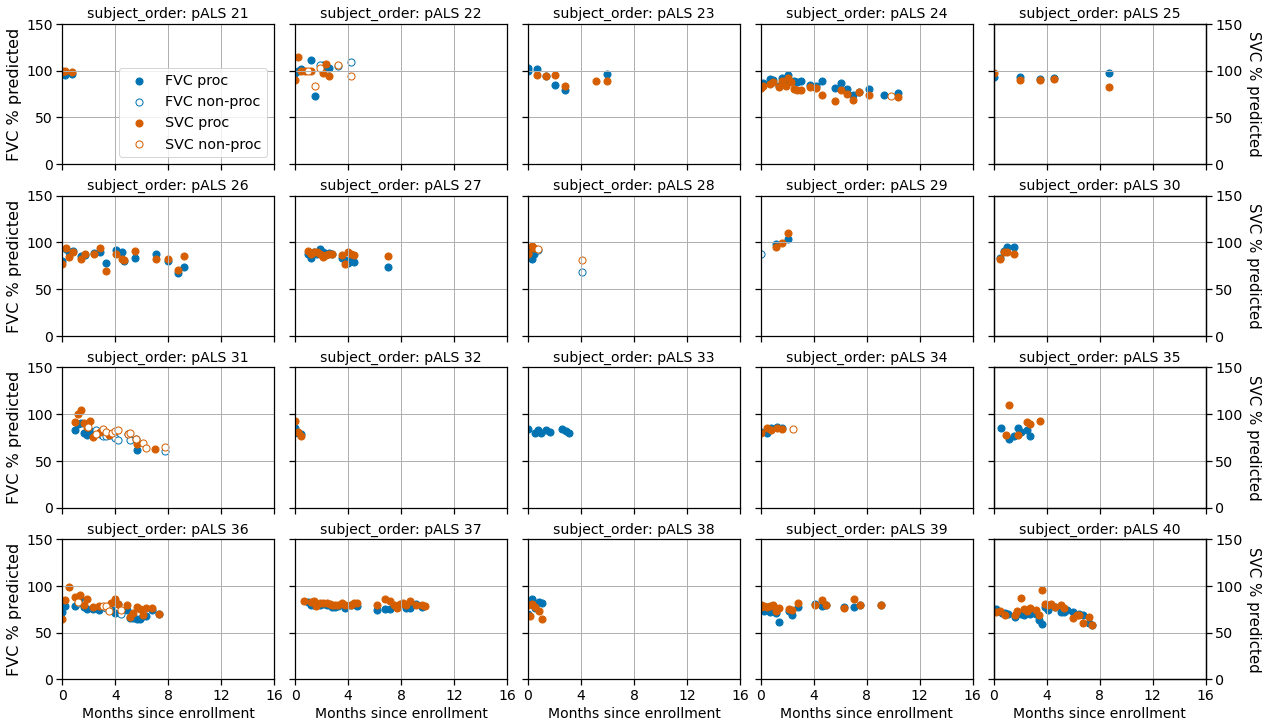

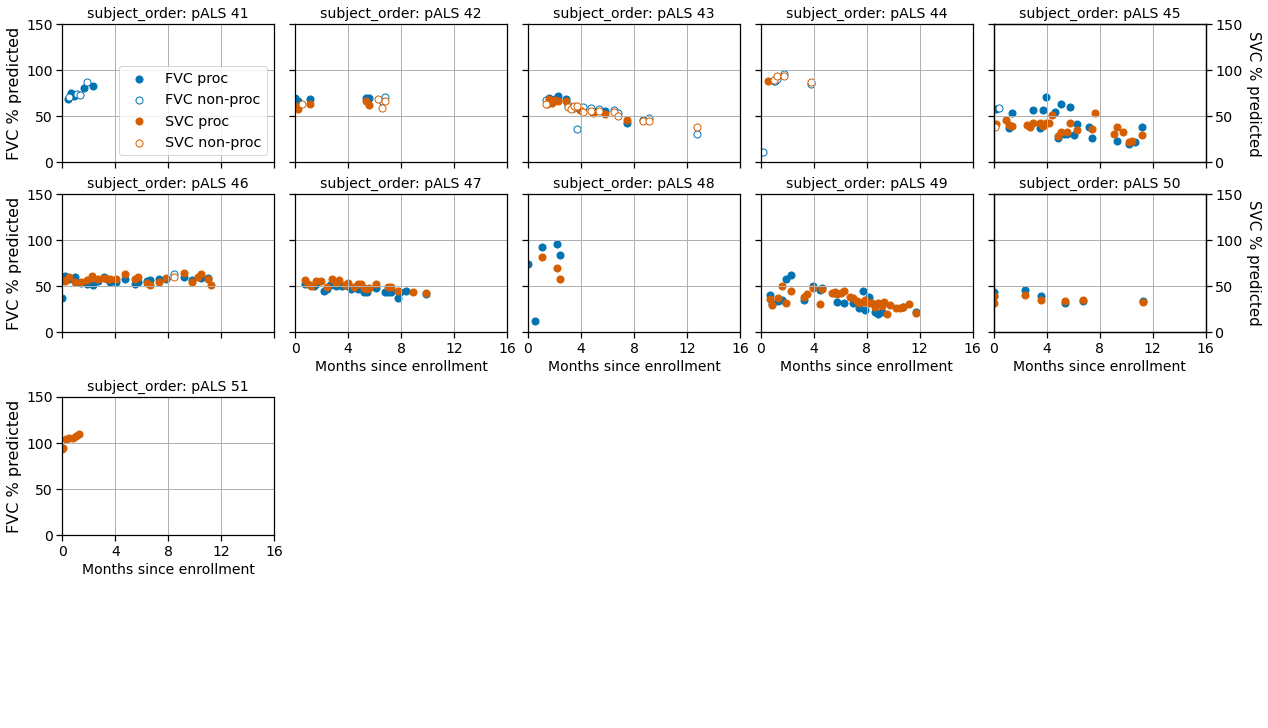

In [5]:
time_col = "months_since_first_session"
margin = 1 if time_col == "months_since_first_session" else 30
# xlim = df_zephyrx_new[time_col].min()-margin, df_zephyrx_new[time_col].max()+margin
xlim = (0, 16)

df_order = df_data.sort_values('intercept_fvcPercPred_2019', ascending=False).subject_order.unique()

for n_pat in [(0,20), (20, 40), (40, 60)]:
        # titles = [pat['subject_order'] for _, pat in df_order.iloc[n_pat[0]:n_pat[1]].iterrows()]
        fig = plot_trajectory_panels3(
                        df_data, 
                        df_order[n_pat[0]:n_pat[1]],# all_patients[n_pat[0]:n_pat[1]],
                        time_col=time_col,
                        limit = None,
                        data_dict = data_dict_fvc_svc,
                        ylim = (-0.0, 150),
                        # ylim = (50, 150),
                        # ylim = (0, 100),
                        xlim = xlim,
                        do_legend= False,
                        mute_titles= False,
                        mute_right_ticks= True,
                        do_external_legend= False,
                        mute_x_ticks= True,
                        plot_regression_line= False,
                        extend_regression= False,
                        fill_between= False,
                        # titles = titles,
                        fs = 14,
                        label_y={'fvcPercPred_2019': 'FVC % predicted', 'vcPercPred': 'SVC % predicted'}, 
                        xlabel='Months since enrollment',
                        #alpha=0.8
                )